In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, BatchNormalization, PReLU, DepthwiseConv2D, Add, Flatten, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Directories for the dataset
train_dir = '/content/drive/MyDrive/dataset_path/dataset_path/train'
val_dir = '/content/drive/MyDrive/dataset_path/dataset_path/val'
test_dir = '/content/drive/MyDrive/dataset_path/dataset_path/test'

# Image parameters
img_height, img_width = 224, 224
batch_size = 5  # Reduce batch size for small dataset

# Data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# MobileFaceNet implementation
def conv_block(inputs, filters, kernel_size, strides, padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = PReLU(shared_axes=[1, 2])(x)
    return x

def depthwise_conv_block(inputs, kernel_size, strides, padding='same', depth_multiplier=1):
    x = DepthwiseConv2D(kernel_size, strides=strides, padding=padding, depth_multiplier=depth_multiplier)(inputs)
    x = BatchNormalization()(x)
    x = PReLU(shared_axes=[1, 2])(x)
    return x

def residual_block(inputs, filters, strides=1, use_res_connect=True):
    shortcut = inputs
    x = conv_block(inputs, filters, kernel_size=(1, 1), strides=1)
    x = depthwise_conv_block(x, kernel_size=(3, 3), strides=strides)
    x = conv_block(x, filters, kernel_size=(1, 1), strides=1)

    if use_res_connect:
        x = Add()([x, shortcut])
    return x

def MobileFaceNet(input_shape):
    inputs = Input(shape=input_shape)

    x = conv_block(inputs, filters=64, kernel_size=(3, 3), strides=2)
    x = depthwise_conv_block(x, kernel_size=(3, 3), strides=1)

    # Add several residual blocks
    for _ in range(4):
        x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, strides=2, use_res_connect=False)
    for _ in range(6):
        x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, strides=2, use_res_connect=False)
    for _ in range(2):
        x = residual_block(x, filters=256)

    x = conv_block(x, filters=512, kernel_size=(1, 1), strides=1)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)

    model = Model(inputs, x, name='MobileFaceNet')
    return model

# Define the base model
base_model = MobileFaceNet(input_shape=(img_height, img_width, 3))
x = base_model.output
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(512, activation='relu')(x)  # Reduced size of dense layer
x = Dropout(0.5)(x)  # Add another dropout layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower initial learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for saving the best model, early stopping, and reducing learning rate
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')  # Increase patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6, mode='min')  # Adjust patience and min_lr

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=max(1, train_generator.samples // batch_size),
    validation_data=val_generator,
    validation_steps=max(1, val_generator.samples // batch_size),
    epochs=200,  # Increase total number of epochs
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Load the best model
model.load_weights('best_model.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=max(1, test_generator.samples // batch_size))
print(f'Test accuracy: {test_accuracy:.2f}')



Found 317 images belonging to 53 classes.
Found 54 images belonging to 53 classes.
Found 53 images belonging to 53 classes.
Epoch 1/200
63/63 [==============================] - 40s 116ms/step - loss: 4.1097 - accuracy: 0.0353 - val_loss: 3.9777 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/200
63/63 [==============================] - 5s 81ms/step - loss: 4.1004 - accuracy: 0.0192 - val_loss: 3.9855 - val_accuracy: 0.0200 - lr: 1.0000e-04
Epoch 3/200
63/63 [==============================] - 5s 79ms/step - loss: 4.0407 - accuracy: 0.0128 - val_loss: 4.0082 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/200
63/63 [==============================] - 5s 78ms/step - loss: 3.9499 - accuracy: 0.0224 - val_loss: 3.9982 - val_accuracy: 0.0200 - lr: 1.0000e-04
Epoch 5/200
63/63 [==============================] - 5s 78ms/step - loss: 3.8702 - accuracy: 0.0385 - val_loss: 4.0244 - val_accuracy: 0.0200 - lr: 1.0000e-04
Epoch 6/200
63/63 [==============================] - 5s 80ms/step - los

11/11 [==============================] - 0s 22ms/step


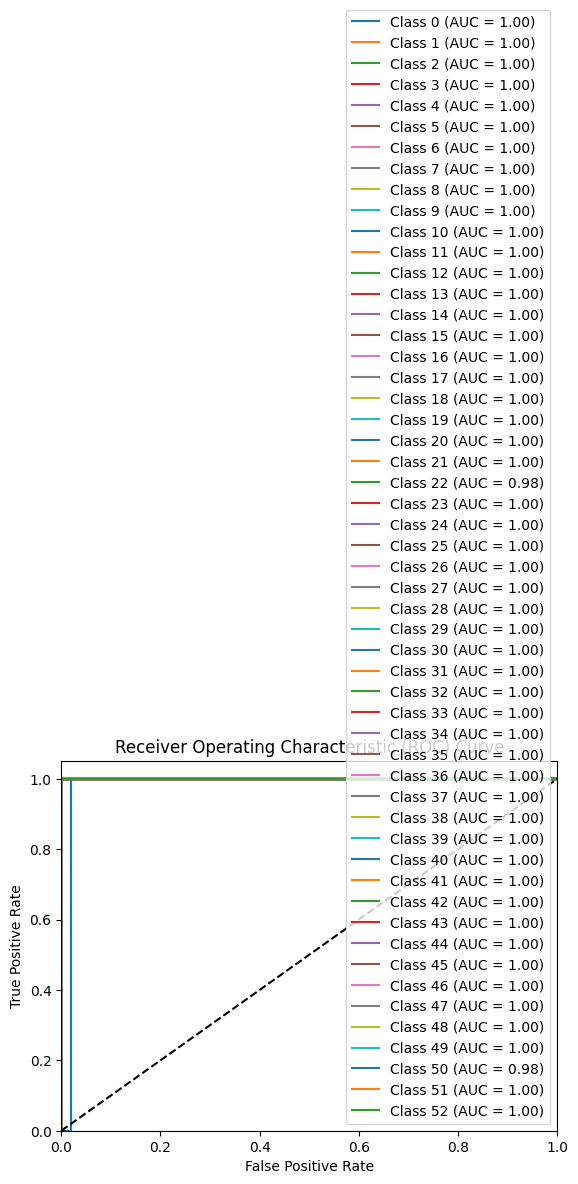

In [ ]:
# Generate predictions
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
y_true = test_generator.classes

# Generate predictions for all samples
y_pred = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure that y_true and y_pred_classes have the same length
assert len(y_true) == len(y_pred_classes), f"Mismatch: len(y_true) = {len(y_true)}, len(y_pred_classes) = {len(y_pred_classes)}"

# ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



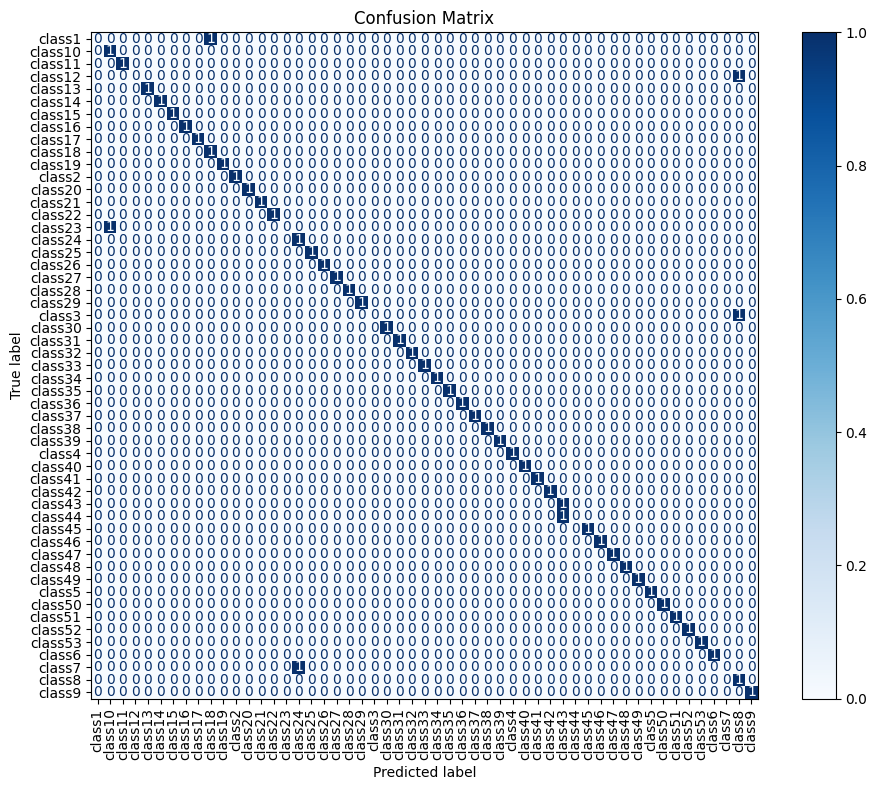

In [ ]:
plt.figure(figsize=(10, 8))  # Increase the figure size for the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()